In [1]:
## Imports 
%matplotlib inline

STRUCTURED = '/Users/maru/MyCode/structured'
IMDB_DATA='/Users/maru/MyCode/data/imdb'
SRAA_DATA='/Users/maru/MyCode/data/sraa'
TWIITER_DATA = '/Users/maru/MyCode/data/twitter'

# STRUCTURED = '/Users/maru/My Code/structured'
# IMDB_DATA='/Users/maru/Dataset/aclImdb'
# SRAA_DATA='/Users/maru/Dataset/aviation/data'
# TWIITER_DATA = '/Users/maru/Dataset/twitter'

import sys
import os
sys.path.append(os.path.abspath(STRUCTURED))
sys.path.append(os.path.abspath('C:/cygwin/home/mramire8/python_code/structured/'))

import learner

from utilities.datautils import load_dataset
import experiment.base as exp


import utilities.experimentutils as exputil
import utilities.datautils as datautil
import numpy as np
import nltk
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('bmh')

In [2]:
## Get the data ready

vct = exputil.get_vectorizer({'vectorizer':'bow', 'limit':None, 'min_size':2})

imdb =  load_dataset("imdb",IMDB_DATA, keep_subject=True)

imdb.train.bow = vct.fit_transform(imdb.train.data)
imdb.test.bow = vct.transform(imdb.test.data)



In [3]:
# Test reference, classifier with all data
clf2 = exputil.get_classifier('lrl1', parameter=1)
clf2.fit(imdb.train.bow, imdb.train.target)
print "Full accuracy", metrics.accuracy_score(imdb.test.target, clf2.predict(imdb.test.bow))



Full accuracy 0.888510944816


In [6]:
def iterate_sentences(documents):
    for d in documents:
        for s in d:
            yield s


def featurize_sents(docs_text, doc_labels, vct):
    sent_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
    doc_sents = sent_splitter.tokenize_sents(docs_text)
    sizes = [len(d) for d in doc_sents]
    labels = [[l]*s for l, s in zip(doc_labels, sizes)]
    
    sents_bow = vct.transform(iterate_sentences(doc_sents))
    labels = [l for l in iterate_sentences(labels)]
    
    return sents_bow, labels



In [67]:
def test_bootstrap(data_bow, data_y, data_txt, bt_size, threshold=0.0, vct=None):
    
    N = bt_size
    
    # Sample N random documents
    x_txt = data_txt[:N] # get the document subsample: docs_text
    x = data_bow[:N]
    y = data_y[:N]  # document bow, target
    
    # Train a classifier
    clf_d = exputil.get_classifier('lrl1', parameter=1) 
    clf_d.fit(x, y) # document bow, target
    
    s_bow,s_target = featurize_sents(x_txt, y, vct)

    accu_docs  = metrics.accuracy_score(y, clf_d.predict(x))
    preds = clf_d.predict(s_bow)
    probas = clf_d.predict_proba(s_bow)
    unc = probas.min(axis=1)
    preds = np.array([lbl if un < threshold else 2  for lbl, un in zip(preds, unc)])
    accu_sents = metrics.accuracy_score(s_target, preds)

    mat = metrics.confusion_matrix(s_target, preds, labels=[0,1,2])
    print "Uncertainty: %s" % (np.mean(probas.min(axis=1)))
#     print "Sample size: %s docs, %s sents." % (x.shape[0],s_bow.shape[0]) 
    return  accu_sents, accu_docs, mat

def save_fig():
    plt.savefig("../graphs/" + "-".join(["student_sent","bootstrap"]) + ".pdf", bbox_inches="tight", dpi=200, transparent=True)

In [90]:
from tabulate import tabulate 
N=10000

def test_sent_bootstrap(data, N, vct, runs=5, threshold=0.0):
    res = {}
    for run in range(runs):
        rnd = np.random.RandomState(run + (100*run))
        sample = rnd.permutation(len(data.train.data)) 
        x = data.train.data[sample]
        y = data.train.target[sample]
        xd = data.train.bow[sample]
        res['run-%s' % run] = test_bootstrap(xd, y, x, N, vct=vct,threshold=threshold)
    return res

def print_res(res, col=0):
    print tabulate([[k, "%s" % v[col]] for k,v in sorted(res.items())], headers=['Test', 'Accu.Sent.'], floatfmt=".4f")
    print "Avg. Accuracy on sentences %.4f" % np.mean([v[col] for v in res.values()])    
    


In [33]:
sizes = [100, 250, 500, 1000, 2000, 3000]
results = [test_sent_bootstrap(imdb, size, vct,threshold=0.0) for size in sizes]

for s,res in zip(sizes,results): 
    print "Training size:", s
    print_res(res)

Sample size: 100 docs, 1199 sents.
Sample size: 100 docs, 1434 sents.
Sample size: 100 docs, 1304 sents.
Sample size: 100 docs, 1120 sents.
Sample size: 100 docs, 1288 sents.
Sample size: 100 docs, 1350 sents.
Sample size: 100 docs, 1171 sents.
Sample size: 100 docs, 1211 sents.
Sample size: 100 docs, 1087 sents.
Sample size: 100 docs, 1227 sents.
Sample size: 250 docs, 3172 sents.
Sample size: 250 docs, 3261 sents.
Sample size: 250 docs, 3263 sents.
Sample size: 250 docs, 2897 sents.
Sample size: 250 docs, 3288 sents.
Sample size: 250 docs, 3043 sents.
Sample size: 250 docs, 3048 sents.
Sample size: 250 docs, 3278 sents.
Sample size: 250 docs, 2954 sents.
Sample size: 250 docs, 3018 sents.
Sample size: 500 docs, 5862 sents.
Sample size: 500 docs, 6432 sents.
Sample size: 500 docs, 6349 sents.
Sample size: 500 docs, 5844 sents.
Sample size: 500 docs, 6486 sents.
Sample size: 500 docs, 5943 sents.
Sample size: 500 docs, 6123 sents.
Sample size: 500 docs, 6695 sents.
Sample size: 500 doc

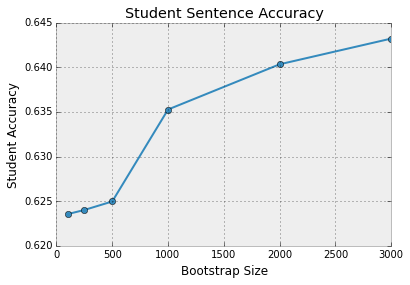

In [38]:
plt.plot(sizes, [np.mean([v[0] for v in r.values()]) for r in results], 'o-')
plt.title('Student Sentence Accuracy')
plt.xlabel('Bootstrap Size')
plt.ylabel('Student Accuracy')
save_fig()

In [99]:
res100= test_sent_bootstrap(imdb, 100, vct,threshold=0.45)

Uncertainty: 0.3937762411
Uncertainty: 0.404541891641
Uncertainty: 0.408992843351
Uncertainty: 0.398845096976
Uncertainty: 0.390349562173


In [117]:
def print_res_mat(res, col=2, perc=True):
    if perc:
        print "\n\n".join(tabulate(1.*np.array(v[col])/np.sum(v[col]), headers=['neg', 'pos','neu'], floatfmt=".4f") for k,v in sorted(res.items()))
    else:
        print "\n\n".join(tabulate(v[col], headers=['neg', 'pos','neu'], floatfmt=".0f") for k,v in sorted(res.items()))

    print "\nAverage"
    mat_sum = np.sum([np.array(v[col]) for v in res.values()],axis=0)
    average = 1.* mat_sum /len(res.values())
#     print "Average: \n%s" % (average / mat_sum) 
#     print np.mean([v[col] for v in res.values()])  
    print 
    print tabulate( average / average.sum() ,headers=['neg', 'pos','neu'], floatfmt=".4f")

print_res(res100, col=0)
print 
print_res_mat(res100, col=2, perc=True)

Test      Accu.Sent.
------  ------------
run-0         0.3870
run-1         0.3410
run-2         0.3788
run-3         0.3545
run-4         0.4325
Avg. Accuracy on sentences 0.3787

   neg     pos     neu
------  ------  ------
0.1393  0.1251  0.2352
0.0634  0.2477  0.1893
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.1695  0.0600  0.2329
0.1151  0.1715  0.2510
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.1695  0.0690  0.2278
0.0706  0.2094  0.2538
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.1946  0.0786  0.2920
0.0777  0.1598  0.1973
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.2648  0.1102  0.1894
0.1304  0.1677  0.1374
0.0000  0.0000  0.0000

Average

   neg     pos     neu
------  ------  ------
0.1875  0.0876  0.2339
0.0927  0.1909  0.2074
0.0000  0.0000  0.0000


In [121]:
print_res_mat(test_sent_bootstrap(imdb, 100, vct, runs=10, threshold=0.47),perc=True)

Uncertainty: 0.393687099862
Uncertainty: 0.404540635658
Uncertainty: 0.408970621092
Uncertainty: 0.398910451305
Uncertainty: 0.3902054474
Uncertainty: 0.407326784079
Uncertainty: 0.388660783799
Uncertainty: 0.393995470335
Uncertainty: 0.396654893925
Uncertainty: 0.392086514257
   neg     pos     neu
------  ------  ------
0.1593  0.1468  0.1935
0.0751  0.2702  0.1551
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.1764  0.0704  0.2155
0.1199  0.1932  0.2245
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.1863  0.0851  0.1948
0.0982  0.2285  0.2071
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.2045  0.1018  0.2589
0.0821  0.1893  0.1634
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.2764  0.1149  0.1731
0.1374  0.1739  0.1242
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.1800  0.0993  0.2615
0.0763  0.1867  0.1963
0.0000  0.0000  0.0000

   neg     pos     neu
---

In [123]:
print_res_mat(test_sent_bootstrap(imdb, 100, vct, runs=10, threshold=1.0),perc=True)

Uncertainty: 0.393480770536
Uncertainty: 0.40454365929
Uncertainty: 0.40899798975
Uncertainty: 0.398906094034
Uncertainty: 0.390245004565
Uncertainty: 0.407346335169
Uncertainty: 0.388594760964
Uncertainty: 0.393988853305
Uncertainty: 0.396561889741
Uncertainty: 0.392162318857
   neg     pos     neu
------  ------  ------
0.3228  0.1768  0.0000
0.1985  0.3019  0.0000
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.3731  0.0893  0.0000
0.3166  0.2211  0.0000
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.3482  0.1181  0.0000
0.2569  0.2768  0.0000
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.3964  0.1688  0.0000
0.1911  0.2437  0.0000
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.4356  0.1289  0.0000
0.2407  0.1949  0.0000
0.0000  0.0000  0.0000

   neg     pos     neu
------  ------  ------
0.3859  0.1548  0.0000
0.2133  0.2459  0.0000
0.0000  0.0000  0.0000

   neg     pos     neu
---

In [130]:
print_res(test_sent_bootstrap(imdb, 100, vct, runs=10, threshold=1.0),col=0)

Uncertainty: 0.393486837617
Uncertainty: 0.40442502299
Uncertainty: 0.408965169799
Uncertainty: 0.398911769809
Uncertainty: 0.390482255014
Uncertainty: 0.407345436525
Uncertainty: 0.388333397011
Uncertainty: 0.393997444234
Uncertainty: 0.396578994563
Uncertainty: 0.392147312406
Test      Accu.Sent.
------  ------------
run-0         0.6247
run-1         0.5983
run-2         0.6250
run-3         0.6384
run-4         0.6304
run-5         0.6319
run-6         0.6157
run-7         0.6235
run-8         0.6256
run-9         0.6243
Avg. Accuracy on sentences 0.6238
